# ML/NLP data scientist take-home exercise


The 2019 coronavirus disease (COVID-19, https://en.wikipedia.org/wiki/Coronavirus_disease_2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease has spread globally, resulting in the 2019–20 coronavirus pandemic.
 
Research into a solution for this problem is at full steam and, so far, more than 2000 research papers related to this have been published. As this number grows, keeping track of what is happening, recent results, etc., is becoming harder and harder. This is where modern advances in AI, ML and NLP are called for coming into action.

## Your task
 
Your mission is to create a report or dashboard that can be used by decision-makers and researchers to know what science results are being produced.
 
## Data
 
Many institutions and organizations, like the World Health Organization (WHO, https://www.who.int), or the Center for Disease Control and Prevention (CDC, https://www.cdc.gov) are gathering data and information related to the pandemic.
 
One of these organizations is the MIDAS Coordination Center (https://midasnetwork.us/mcc/). They are actively compiling and sharing information through the GitHub repository https://github.com/midas-network/COVID-19. In particular, they are sharing an export their Mendeley paper collection as XML files in  
https://github.com/midas-network/COVID-19/tree/master/documents/mendeley_library_files/xml_files
 
**Note:** You are expected to use the latest XML as the source of documents but you are free to cross the information stored here with other freely available on the web.

## Tasks
 
Given a list of papers create a report with the results of:
 
1. Read the most recent MIDAS Mendeley paper library XML file.
2. Generate groups of similar papers and assign a meaningful label or group of tags to each group.
3. Outline what papers inside each group better represent that group.
4. For each paper, provide a brief "one-liner" description of what the paper's main idea is.
5. Identify papers that represent potential breakthroughs

In [1]:
import pandas as pd

dataset = pd.read_pickle('./dataset_covid.pkl')

# Task 2

## Pre-processing

In order to start modeling and form the term x document matrix, we need to start with pre-processing the abstracts. We employ the follwing steps:

- Remove HTML tags
- Remove Competing Interest Statement
- Remove Numbers, Punctuations, and Non-English characters.
- Remove stopwords
- Remove abstracts that are shorter than a certain length (10 words).

We also identified a number of articles that contain chinese characters. This is probably due to translation.

In [2]:
import re

def pre_process(text):
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&amp', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    if 'Competing Interest Statement' in text:
        text = text[0:text.find('Competing Interest Statement')]
    return text

dataset['text'] = dataset['abstract'].apply(pre_process)

## Tokenization

We use the (sci)spacy package (en_core_sci_md) to convert the abstracts into a tokenized representation. 

In [3]:
import spacy

nlp = spacy.load('en_core_sci_md')

In [4]:
from scispacy.custom_tokenizer import combined_rule_tokenizer

nlp.tokenizer = combined_rule_tokenizer(nlp)

In [5]:
def spacy_tokenizer(doc):
    return [word.lemma_.lower() for word in nlp(doc) if word.is_alpha and not (word.is_stop or word.is_punct or word.is_space or len(word) < 3)]

%time dataset['tokens'] = dataset['text'].apply(spacy_tokenizer)

CPU times: user 31.8 s, sys: 2.53 s, total: 34.4 s
Wall time: 37.1 s


In [6]:
# custom stopwords

stops = ['covid-19', '2019-ncov', 'sars-cov-2', 'sars-cov', 'outbreak', 'china', 'wuhan', 'patient', 'case', 'coronavirus', 'coronaviruse']

dataset['tokens'] = dataset['tokens'].apply(lambda x: [word for word in x if word not in stops])

As a baseline we use a vectorizer with trigram and min_df = 3 and max_df = 0.85.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def identity(args): # no need for tokenization
    return args

vectorizer = TfidfVectorizer(min_df=3, max_df=0.85, ngram_range=(1, 3), stop_words=None, lowercase=False, tokenizer=identity)

In [8]:
tfidf = vectorizer.fit_transform(dataset['tokens'])

In [9]:
# words with highest tf-idf value

pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending=False)[:20]

model           22.340629
epidemic        21.813385
infection       21.636672
number          21.302103
disease         20.479660
estimate        19.697288
virus           19.003399
transmission    18.057128
datum           17.110725
clinical        16.652991
novel           16.239916
report          15.857601
day             15.794778
study           15.154594
spread          14.483273
cell            14.444726
result          14.301849
severe          14.041276
city            14.021917
control         13.914435
dtype: float64

## Hierarchical Agglomerative Clustering (HAC)

We use *ward* algorithm for clustering the documents. In this method, observations are treated separately as singleton clusters. Then, compute the Euclidean distance of each pair and successively merge the most similar clusters. Repeated the previous step until the final optimal clusters are formed.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
np.random.seed(42)

dist = 1 - cosine_similarity(tfidf)

#define the linkage_matrix using ward clustering pre-computed distances

%time linkage_matrix = linkage(dist, method='ward')

CPU times: user 303 ms, sys: 6.04 ms, total: 309 ms
Wall time: 315 ms


A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering. Starting from each document at the bottom, there is a vertical line connected to a horizontal line. The height of that horizontal line shows the distance at which this instance was merged with another instance to form a cluster. We can visualize the dendogram in full or truncated mode.

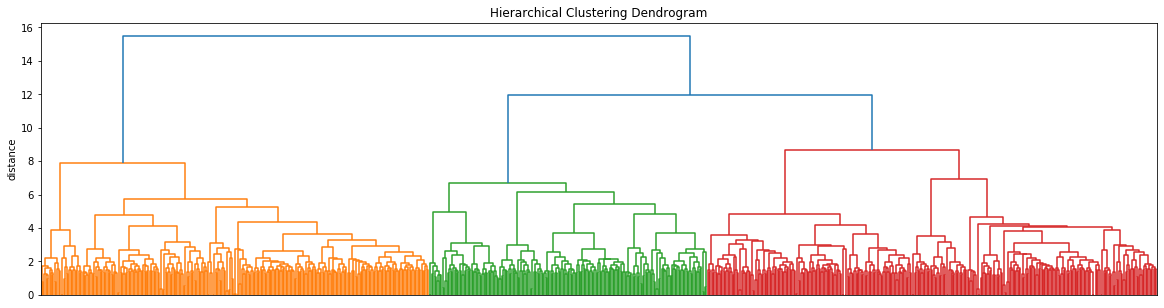

In [11]:
import pylab as plt

plt.figure(figsize=(20, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(linkage_matrix)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

## Determining the Number of Clusters

There is no golden method to pick the number of clusters for all cases. [Wikipedia](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) lists a couple of common methods that include avoiding it using a hierarchical clustering method. 

In general, a huge jump in distance is typically what we're interested in if we want to argue for a certain number of clusters. Such distance jumps / gaps in the dendrogram are indicators of a suboptimal merge, i.e. two clusters that should not have been merged. 

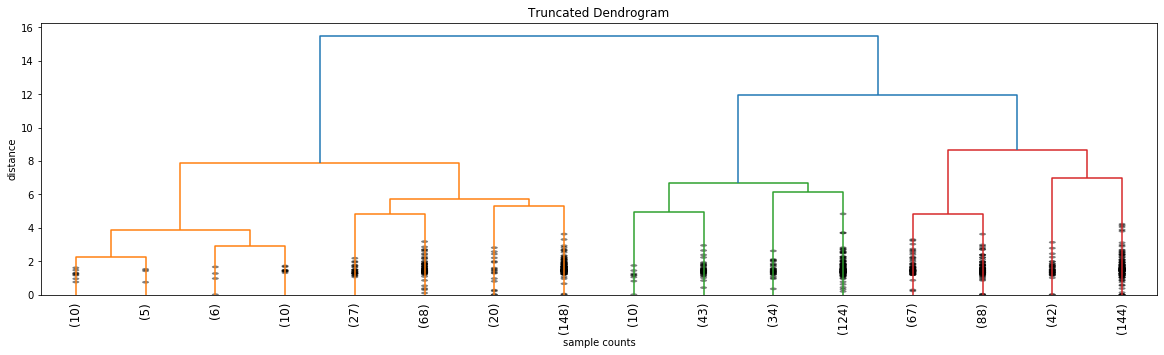

In [12]:
plt.figure(figsize=(20, 5))
plt.title('Truncated Dendrogram')
plt.xlabel('sample counts')
plt.ylabel('distance')

dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=3,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True)

plt.show()

In [13]:
from scipy.cluster.hierarchy import fcluster

max_d = 5.6
dataset['cluster'] = fcluster(linkage_matrix, max_d, criterion='distance')
dataset.groupby('cluster').size()

cluster
1     31
2     95
3    168
4     53
5     34
6    124
7    155
8     42
9    144
dtype: int64

## Task 3

To identify the most representative paper of each topic, we employ a simple huristic using the paper with maximum sum of tf-idf value for each cluster, i.e. the paper that contains the majority of the tokens that are representing a particular cluster.

In [17]:
# top word per cluster

terms = vectorizer.get_feature_names()
                  
n_keywords = 10

for k in range(1, 10):
    dd = dataset[dataset['cluster'] == k]
    titles = dd['title'].values
    td = vectorizer.transform(dd['tokens'])
    print('Cluster {}:'.format(k), '|'.join([terms[i] for i in np.argsort(-td.sum(axis=0)).tolist()[0][:n_keywords]]))
    print('Most Representative Paper:')
    print(titles[np.argmax(td.sum(axis=1))])
    print()

Cluster 1: incubation|incubation period|period|day|interval|estimate|serial|serial interval|transmission|onset
Most Representative Paper:
Evolving epidemiology of novel coronavirus diseases 2019 and possible interruption of local transmission outside Hubei Province in China: a descriptive and modeling study

Cluster 2: number|estimate|epidemic|model|hubei|province|growth|reproduction|reproduction number|peak
Most Representative Paper:
Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study.

Cluster 3: model|epidemic|country|transmission|city|number|spread|travel|measure|datum
Most Representative Paper:
Effect of non-pharmaceutical interventions for containing the COVID-19 outbreak: an observational and modelling study

Cluster 4: protein|epitope|cell|receptor|rbd|spike|human|binding|antibody|vaccine
Most Representative Paper:
Insights into Cross-species Evolution of Novel Human Coronavirus 2019

The following clusters are identified based on the tokens with highest tfidf score in each cluster:

    - Cluster 1 is related to epidemiology
    - Cluster 2 is related to transmission patterns
    - Cluster 3 is related to forecasting
    - Cluster 4 is related to vaccine development
    - Cluster 5 is related to theraputics
    - Cluster 6 is related to genomics
    - Cluster 7 is related to clinical presentation
    - Cluster 8 is related to clinical screening and testing
    - Cluster 9 is related to fatality and risk

## Dimensionality Reduction

UMAP is a general purpose manifold learning and non-linear dimension reduction algorithm. At its core, UMAP works very similarly to t-SNE - both use graph layout algorithms to arrange data in low-dimensional space. In the simplest sense, UMAP constructs a high dimensional graph representation of the data then optimizes a low-dimensional graph to be as structurally similar as possible. While the mathematics UMAP uses to construct the high-dimensional graph is advanced, the intuition behind them is remarkably simple.

In [18]:
%%time

import umap.umap_ as umap

umap_embr = umap.UMAP(n_neighbors=10, metric='hellinger', min_dist=0.1, random_state=42)
embedding = umap_embr.fit_transform(tfidf)
embedding = pd.DataFrame(embedding, columns=['x','y'])

CPU times: user 9 s, sys: 123 ms, total: 9.13 s
Wall time: 10.5 s


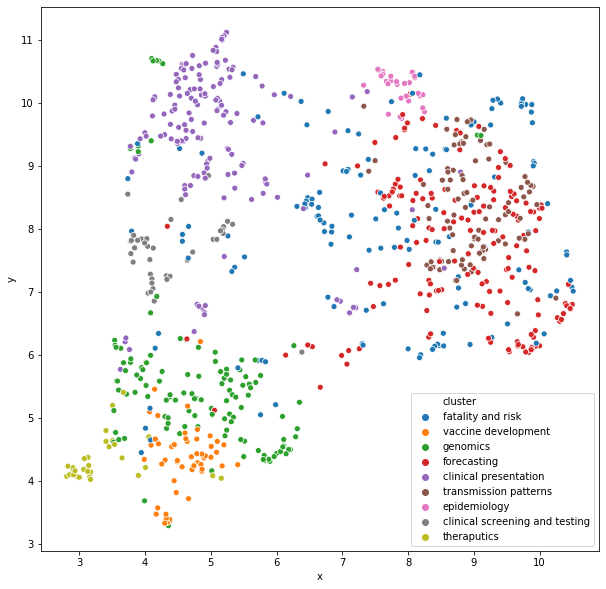

In [19]:
import seaborn as sns

clusters = [
    'epidemiology',
    'transmission patterns',
    'forecasting',
    'vaccine development',
    'theraputics',
    'genomics',
    'clinical presentation',
    'clinical screening and testing',
    'fatality and risk'
]

plt.figure(figsize=(10, 10))
embedding['cluster'] = dataset['cluster'].apply(lambda x: clusters[x-1])
sns.scatterplot(data=embedding, x='x', y='y', hue='cluster')

The 2d representation of the documents in the tfidf space shows small clusters of documents along with 3 big larger clusters. This representation somewhat verifies the overall results of ward clustering algorithm.

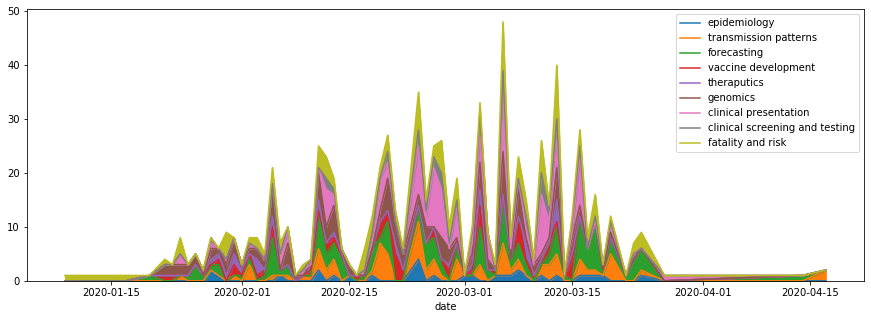

In [20]:
# Clusters Over Time

dataset.pivot_table(index='date', columns='cluster', aggfunc='size', fill_value=0).plot(kind='area', figsize=(15,5)).legend(clusters)

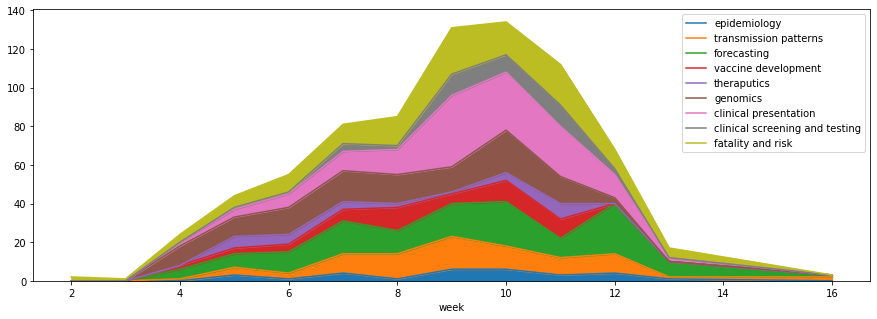

In [21]:
dataset['week'] = pd.to_datetime(dataset['published']).dt.week

dataset.pivot_table(index='week', columns='cluster', aggfunc='size', fill_value=0).plot(kind='area', figsize=(15,5)).legend(clusters)

## Topic Modeling

HAC provides some insight into the general themes of the corpus. However, there is not necessarily a 1-1 mapping between documents and clusters, i. e. some papers might discuss multiple topics from the themes identified using clustering. 

Non-negative Matrix Factorization is a linear-algeabreic model, that factors high-dimensional vectors into a low-dimensionality representation. Given the original term document matrix A, one can obtain two matrices W and H, such that A = WH.

- A (term document matrix) — input that contains which words appear in which documents.
- W (basis vectors) — the topics discovered from the documents.
- H (coefficient matrix) — the membership weights for the topics in each document.

While we can use other (probabilistic) topic modeling techniques such as PLSA and LDA, the NMF model seem to perform better on smaller datasets. Nontheless, the process of identifying topics are fairly similar and there are multiple libraries such as gensim and tomotopy that implement these methods. 


### Evaluation

Similar to clustering, all topic modeling techniques require a mechanism to evaluate the parameters of the model including but not limited to the number of topics. The body of research ([1]) on evaluating topic modeling falls into the following categories:

- Eyeballing the results similar to our approach for HAC
- Intrinsic evaluation based on metrics such as coherence, perplexity, and log likelihood
- Extrinsic evaluation based on a subset of labeled examples or other external information

For the task at hand, we used the coherence score [2] and the best model based on the results was the model with 12 topics.

    [1] Chang et. al Reading Tea Leaves: How Humans Interpret Topic Models, NIPS 2009
    [2] Röder, Michael, Andreas Both, and Alexander Hinneburg. "Exploring the space of topic coherence measures." Proceedings of the eighth ACM international conference on Web search and data mining. 2015.

In [22]:
%%time
from gensim import corpora, models
np.random.seed(42)

# Create a corpus from a list of texts
texts = dataset['tokens'].values
dictionary = corpora.Dictionary(texts, prune_at=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: user 557 ms, sys: 49.7 ms, total: 606 ms
Wall time: 667 ms


In [23]:
%%time
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

coh_list = []
for n_topics in range(3,20+1):
    # Train the model on the corpus
    nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    # Estimate coherence
    cm = CoherenceModel(model=nmf, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence_per_topic() # get coherence value
    coh_list.append(coherence)

CPU times: user 13.1 s, sys: 985 ms, total: 14.1 s
Wall time: 8.61 s


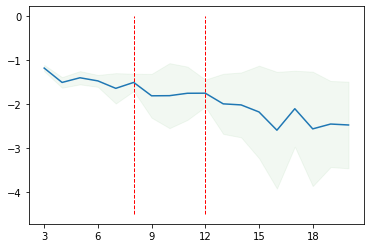

In [25]:
# Coherence scores:
coh_means = np.array([np.mean(l) for l in coh_list])
coh_stds = np.array([np.std(l) for l in coh_list])

plt.xticks(np.arange(3, 20+1, 3.0))
plt.plot(range(3,20+1), coh_means)
plt.fill_between(range(3,20+1), coh_means-coh_stds, coh_means+coh_stds, color='g', alpha=0.05)
plt.vlines([12], -4.5, 0, color='red', linestyles='dashed',  linewidth=1)
plt.vlines([8], -4.5, 0, color='red', linestyles='dashed',  linewidth=1);

In [26]:
n_topics = 12

nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)

Extracting the coefficients (H) matrix from the output of the model. The H matrix is a representation (embedding) of the document in lower dimension (n_topic).

In [27]:
distributions = []
for bow in corpus:
    distri = nmf[bow]
    distributions.append(distri)

nmf_embedding = np.zeros((len(distributions), n_topics))
for i, distri in enumerate(distributions):
    for j, prob in distri:
        nmf_embedding[i, j] = prob

We choose the most prominent topic (largest coefficient) as the single label for the document. The basis vectors can be used to identify top words per topic.

In [28]:
embedding['topic'] = nmf_embedding.argmax(axis=1)
embedding.groupby('topic').size()

topic
0      72
1      27
2      80
3      63
4      42
5      84
6      68
7      55
8      94
9      79
10    103
11     79
dtype: int64

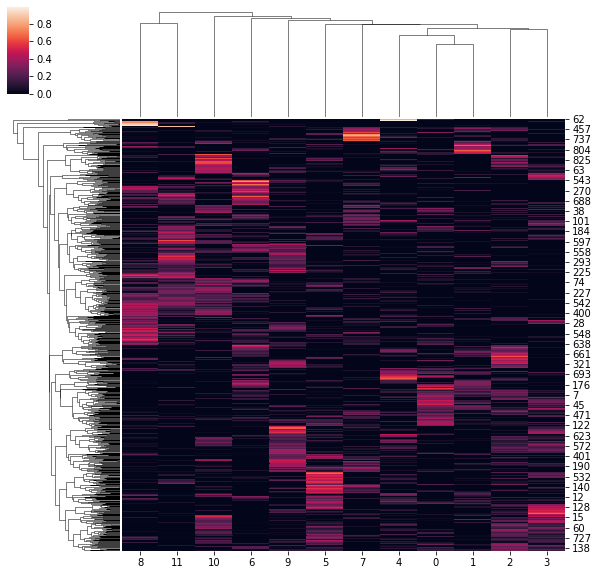

In [29]:
sns.clustermap(nmf_embedding)

As it is inferable from the clustermap, similar documents group together and form clusters in the NMF space. We can leverage this low dimensional representation to identify the most prominent document for each topic.

We use the following heuristic to extract the central abstract per topic:

    1 - Assign the most prominent topic to each document.
    2 - Calculate the cosine similarity of the documents with the same topic in the topic space.
    3 - Find the central index in the subset of the documents. 
    

In [30]:
topic_assignments = np.argmax(nmf_embedding, axis=1)

central_points = []

for i in range(n_topics):
    sim = cosine_similarity(nmf_embedding[topic_assignments == i])
    central_idx = np.argmax(np.sum(sim, axis=1))
    mapping = np.argwhere(topic_assignments == i).squeeze()
    central_points.append(mapping[central_idx])
    print('Topic {}:'.format(i+1), '|'.join([w for w, v in sorted(nmf.show_topic(i))]))
    print('Most Representative Paper:')
    print(dataset.loc[mapping[central_idx], 'title'])
    print()

Topic 1: characteristic|clinical|confirm|control|datum|include|novel|show|study|time
Most Representative Paper:
Clinical Characteristics and Progression of 2019 Novel Coronavirus-Infected Patients Concurrent Acute Respiratory Distress Syndrome

Topic 2: clinical|country|disease|health|include|method|risk|symptom|treatment|trial
Most Representative Paper:
Clinical Features of Patients Infected with the 2019 Novel Coronavirus (COVID-19) in Shanghai, China

Topic 3: cell|identify|incubation|infection|period|pneumonia|result|severe|show|symptom
Most Representative Paper:
Highly ACE2 Expression in Pancreas May Cause Pancreas Damage After SARS-CoV-2 Infection

Topic 4: city|clinical|confirm|february|health|high|infection|level|treatment|virus
Most Representative Paper:
Therapeutic effects of dipyridamole on COVID-19 patients with coagulation dysfunction

Topic 5: city|compare|disease|group|hospital|infected|infection|novel|proportion|risk
Most Representative Paper:
Epidemiological and clinic

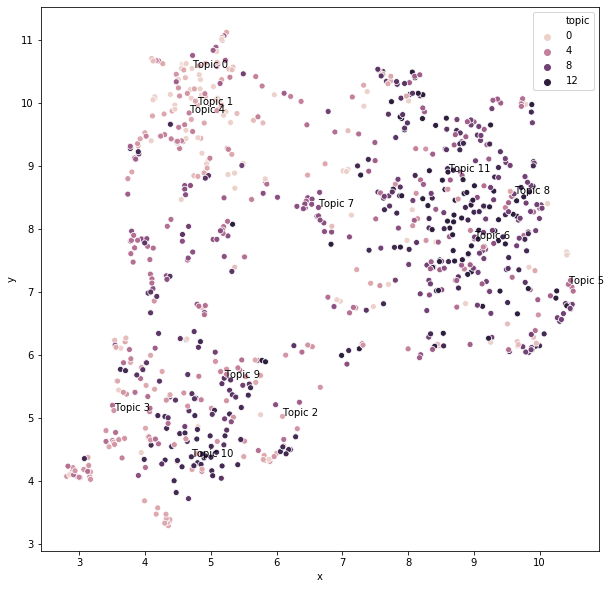

In [31]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=embedding, x='x', y='y', hue='topic')
for i, p in enumerate(central_points):
    x, y = embedding.loc[p, 'x'], embedding.loc[p, 'y']
    plt.annotate('Topic ' + str(i), (x, y))

In [43]:
dataset['topic'] = np.argmax(nmf_embedding, axis=1)
dataset['topic_coef'] = np.max(nmf_embedding, axis=1)

In [44]:
dataset['topics'] = dataset['tokens'].apply(lambda x: nmf[dictionary.doc2bow(x)])

In [52]:
# Documents with Highest Coefficient in Single Topic

for ix, row in dataset.loc[dataset.groupby('topic')['topic_coef'].idxmax()].iterrows():
    print('Highest Coefficient Document for Topic {}:'.format(row['topic']))
    print('|'.join([w for w, v in sorted(nmf.show_topic(row['topic']))]))
    print(row['title'])
    print()

Highest Coefficient Document for Topic 0:
characteristic|clinical|confirm|control|datum|include|novel|show|study|time
Novel coronavirus: From discovery to clinical diagnostics

Highest Coefficient Document for Topic 1:
clinical|country|disease|health|include|method|risk|symptom|treatment|trial
Incidence, clinical characteristics and prognostic factor of patients with COVID-19: a systematic review and meta-analysis

Highest Coefficient Document for Topic 2:
cell|identify|incubation|infection|period|pneumonia|result|severe|show|symptom
Neutrophil-to-Lymphocyte Ratio Predicts Severe Illness Patients with 2019 Novel Coronavirus in the Early Stage

Highest Coefficient Document for Topic 3:
city|clinical|confirm|february|health|high|infection|level|treatment|virus
Clinical Characteristics on 25 Discharged Patients with COVID-19 Virus Returning

Highest Coefficient Document for Topic 4:
city|compare|disease|group|hospital|infected|infection|novel|proportion|risk
Radiological findings from 81 

In [54]:
dataset.to_pickle('./dataset_covid_groups.pkl')